In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import math
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
df = pd.read_csv('/content/data_2005.csv')
df.head()

,Unnamed: 0,Time,Rain_rate,Rain_Attenuation
0,0,2.083222,0.123969,0.277891
1,1,2.083502,0.122079,0.374563
2,2,2.083782,0.120313,0.309713
3,3,2.084062,0.118503,0.406240
4,4,2.084342,0.116721,0.329704


In [ ]:
data = df[['Time','Rain_Attenuation']]
data.head()

,Time,Rain_Attenuation
0,2.083222,0.277891
1,2.083502,0.374563
2,2.083782,0.309713
3,2.084062,0.406240
4,2.084342,0.329704


In [ ]:
def decimal_time(time):
    hours = int(time)
    minutes = (time*60) % 60
    seconds = (time*3600) % 60
    f =  (time*3600000000) % 1000000
    return ("%d:%02d:%02d.%03d" % (hours, minutes, seconds,f))

(87369, 2) (87387, 4)
                        Time  Rain_Attenuation
0 1900-01-01 02:04:59.599919          0.277891
1 1900-01-01 02:05:00.607920          0.374563
2 1900-01-01 02:05:01.615920          0.309713
3 1900-01-01 02:05:02.623920          0.406240
4 1900-01-01 02:05:03.631920          0.329704


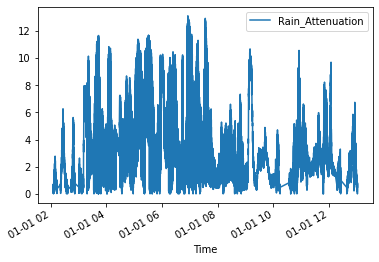

In [ ]:
data['Time'] = data['Time'].apply(lambda x : decimal_time(x))
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S.%f')
data = data.drop_duplicates(subset = ['Time'])
print(data.shape, df.shape)
data1 = data.set_index('Time')
print(data.head())
data1.plot()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
dat = data1.values
sc = MinMaxScaler(feature_range=(0,1))
scaled = sc.fit_transform(dat)

train = scaled[:52370, :]
val =  scaled[52370:69870,:]
test = scaled[69870:, :]
train.shape, test.shape, val.shape

((52370, 1), (17499, 1), (17500, 1))

In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []
x_val = []
y_val = []

n_future = 60
n_past = 30

for i in range(0,len(train)-n_past-n_future+1):
    x_train.append(train[i : i + n_past , 0])     
    y_train.append(train[i + n_past : i + n_past + n_future , 0 ])

for i in range(0,len(val)-n_past-n_future+1):
    x_val.append(val[i : i + n_past , 0])     
    y_val.append(val[i + n_past : i + n_past + n_future , 0 ])

for i in range(0,len(test)-n_past-n_future+1):
    x_test.append(test[i : i + n_past , 0])     
    y_test.append(test[i + n_past : i + n_past + n_future , 0 ])


x_train , y_train = np.array(x_train), np.array(y_train)
x_test , y_test = np.array(x_test), np.array(y_test)
x_val , y_val = np.array(x_val), np.array(y_val)

x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1) )
x_test = np.reshape(x_test, (x_test.shape[0] , x_test.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0] , x_val.shape[1], 1))

x_train.shape,y_train.shape, x_test.shape,y_test.shape, x_val.shape, y_val.shape

((52281, 30, 1),
 (52281, 60),
 (17410, 30, 1),
 (17410, 60),
 (17411, 30, 1),
 (17411, 60))

In [ ]:
from keras.models import Sequential
from keras.layers import GRU,Dense ,Dropout,Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(Bidirectional(GRU(units=2048, return_sequences=True, input_shape = (x_train.shape[1],1))))
model.add(Dropout(0.4))

model.add(Bidirectional(GRU(units=1024, return_sequences=True)))
model.add(Dropout(0.3))

model.add(GRU(units= 1024, return_sequences=True))
model.add(Dropout(0.3))

model.add(GRU(units= 512))
model.add(Dropout(0.2))

model.add(Dense(units = n_future,activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 2)
history = model.fit(x_train, y_train, epochs= 5, batch_size= 32 , validation_data=(x_val, y_val), callbacks = [es], verbose = 1)

Epoch 1/5
1634/1634 [==============================] - 1074s 648ms/step - loss: 0.0316 - val_loss: 0.0031
Epoch 2/5
1634/1634 [==============================] - 1053s 644ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 3/5
1634/1634 [==============================] - 1055s 646ms/step - loss: 0.0051 - val_loss: 0.0034
Epoch 4/5
1634/1634 [==============================] - 1053s 645ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 5/5
1634/1634 [==============================] - 1054s 645ms/step - loss: 0.0046 - val_loss: 0.0026


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 30, 4096)          25202688  
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 4096)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 30, 2048)          31469568  
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 2048)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 30, 1024)          9443328   
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 1024)          0         
_________________________________________________________________
gru_7 (GRU)                  (None, 512)              

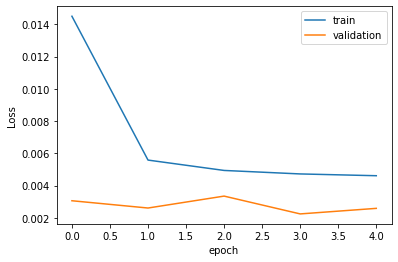

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

plt.show()

In [ ]:
predicted = model.predict(x_test)
predicted = np.reshape(predicted,(predicted.shape[0],predicted.shape[1]))
predicted = sc.inverse_transform(predicted)
ttest = sc.inverse_transform(y_test)
score = math.sqrt(mean_squared_error(ttest,predicted))
print("The rmse score of Rain Attenuation : ",score)

The rmse score of Rain Attenuation :  0.7143300147838241


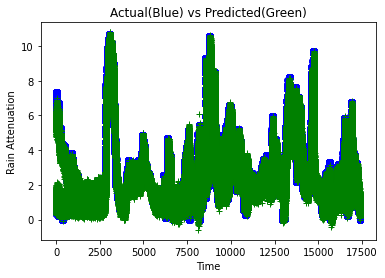

In [ ]:
plt.plot(ttest, 'ro',color = 'blue', label = 'Actual')
plt.plot(predicted,'r+',  color = 'green', label = 'Predicted')
plt.title('Actual(Blue) vs Predicted(Green)')
plt.ylabel('Rain Attenuation')
plt.xlabel('Time')
plt.show()

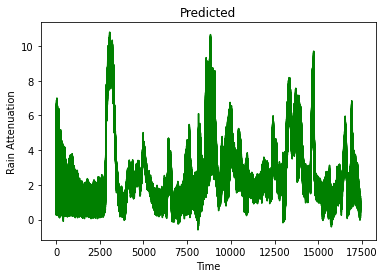

In [ ]:
plt.plot(predicted, 'g')
plt.title('Predicted')
plt.ylabel('Rain Attenuation')
plt.xlabel('Time')
plt.show()

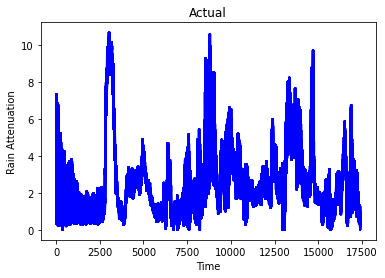

In [ ]:
plt.plot(ttest, 'b')
plt.title('Actual')
plt.ylabel('Rain Attenuation')
plt.xlabel('Time')
plt.show()

In [ ]:
t =  model.predict(x_train)
t = np.reshape(t,(t.shape[0],t.shape[1]))
t = sc.inverse_transform(t)
ttrain = sc.inverse_transform(y_train)
score1 = math.sqrt(mean_squared_error(ttrain,t))
print("The rmse score of Rain Attenuation : ",score1)

The rmse score of Rain Attenuation :  0.8174823964001862


In [ ]:
predicted[:1] # predicted first 60 seconds of rain attenuation

array([[1.3985807 , 5.584532  , 0.68902016, 1.3733919 , 5.7157574 ,
        0.8417392 , 1.4441028 , 5.192781  , 1.2985994 , 0.85202956,
        5.6961846 , 1.071207  , 1.4791882 , 5.232025  , 1.4035028 ,
        1.3196082 , 5.622366  , 0.82866454, 1.0735173 , 5.592204  ,
        1.3888446 , 1.0908307 , 5.6677275 , 0.7060631 , 1.2633452 ,
        5.5641284 , 1.0030508 , 1.2551792 , 5.6311607 , 0.5140262 ,
        1.7941225 , 5.119568  , 1.0085195 , 1.2780439 , 5.0447454 ,
        1.4446542 , 1.5031809 , 4.803402  , 1.5256655 , 0.8022239 ,
        5.936196  , 0.90826064, 1.0770222 , 5.5771227 , 0.8159013 ,
        1.2695993 , 5.798538  , 0.80712825, 1.4540846 , 5.108766  ,
        1.2269826 , 1.5364958 , 5.3408875 , 0.8392149 , 1.7647804 ,
        5.4496427 , 1.1945919 , 1.258873  , 5.1652703 , 1.2278391 ]],
      dtype=float32)

In [ ]:
ttest[:1]# actual first 60 seconds of rain attenuation

array([[0.4863931 , 6.1096525 , 0.93802633, 0.80087681, 6.0924591 ,
        0.57946145, 0.47976963, 6.6557815 , 0.64998772, 0.70990312,
        6.2856115 , 0.44567526, 0.82983904, 6.1649184 , 0.80096164,
        0.63962572, 6.1103466 , 0.81093895, 0.63842396, 6.2718592 ,
        0.85456189, 0.67741301, 6.5479161 , 0.59402715, 0.77328302,
        7.1811098 , 0.43848655, 0.71462997, 6.7417819 , 0.86233653,
        0.86406537, 6.327605  , 0.71256264, 0.63866204, 6.2677843 ,
        0.39102295, 0.57119504, 6.4135442 , 0.50237194, 0.7004401 ,
        6.3500915 , 0.53044744, 0.72251712, 6.3263414 , 0.77745445,
        0.6293441 , 7.3442018 , 0.51665262, 0.61349154, 7.1824108 ,
        0.54376722, 0.64023796, 6.8949164 , 0.68273749, 0.72967855,
        6.7080391 , 0.61972444, 0.64035134, 6.7887398 , 0.60699375]])

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

   Unnamed: 0      Time  Rain_rate  Rain_Attenuation
0           0  3.293891   0.099907          0.000361
1           1  3.294171   0.099968          0.006667
2           2  3.294451   0.100136          0.140382
3           3  3.294731   0.100191          0.067730
4           4  3.296411   0.099586          0.111982
       Time  Rain_Attenuation
0  3.293891          0.000361
1  3.294171          0.006667
2  3.294451          0.140382
3  3.294731          0.067730
4  3.296411          0.111982
(5168, 2) (5168, 4)
                        Time  Rain_Attenuation
0 1900-01-01 03:17:38.796000          0.000361
1 1900-01-01 03:17:39.159600          0.006667
2 1900-01-01 03:17:40.239600          0.140382
3 1900-01-01 03:17:41.319600          0.067730
4 1900-01-01 03:17:47.799600          0.111982
(5168, 1)


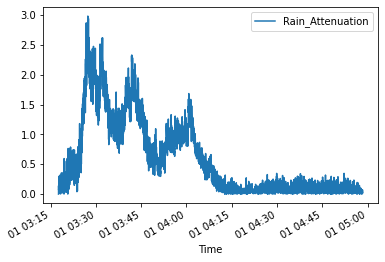

In [ ]:
real_df = pd.read_csv('/content/aug1707.csv')
print(real_df.head())

real_data = real_df[['Time','Rain_Attenuation']]
print(real_data.head())

def decimal_time(time):
    hours = int(time)
    minutes = (time*60) % 60
    seconds = (time*3600) % 60
    f =  (time*3600000000) % 1000000
    return ("%d:%02d:%02d.%03d" % (hours, minutes, seconds,f))

real_data['Time'] = real_data['Time'].apply(lambda x : decimal_time(x))
real_data['Time'] = pd.to_datetime(real_data['Time'], format='%H:%M:%S.%f')
real_data = real_data.drop_duplicates(subset = ['Time'])
print(real_data.shape, real_df.shape)
real_data1 = real_data.set_index('Time')
print(real_data.head())
real_data1.plot()

from sklearn.preprocessing import MinMaxScaler
real_dat = real_data1.values
sc = MinMaxScaler(feature_range=(0,1))
real_test = sc.fit_transform(real_dat)

print(real_test.shape)

In [ ]:
real_x_test = []
real_y_test = []

n_future = 60
n_past = 30

for i in range(0,len(real_test)-n_past-n_future+1):
    real_x_test.append(real_test[i : i + n_past , 0])     
    real_y_test.append(real_test[i + n_past : i + n_past + n_future , 0 ])


real_x_test , real_y_test = np.array(real_x_test), np.array(real_y_test)
real_x_test = np.reshape(real_x_test, (real_x_test.shape[0] , real_x_test.shape[1], 1))

real_x_test.shape,real_y_test.shape

((5079, 30, 1), (5079, 60))

In [ ]:
ox = real_x_test[:30, :, :]
scores = []
actual = []
predict = []

i = 0
while i < (real_x_test.shape[0]-9):
  ox = np.reshape(ox, (ox.shape[0] , ox.shape[1], 1))
  oy = real_y_test[i:i+30, ]
  oy = np.reshape(oy, (oy.shape[0] ,60))
  predicted = model.predict(ox)
  predicted = np.reshape(predicted,(predicted.shape[0],predicted.shape[1]))
  ox = predicted
  predicted = sc.inverse_transform(predicted)
  ttest = sc.inverse_transform(oy)
  score = math.sqrt(mean_squared_error(ttest,predicted))
  actual.extend(ttest)
  predict.extend(predicted)
  scores.append(score)
  i = i+30

In [ ]:
plt.plot(scores)
plt.title('RMSE SCORE')
plt.ylabel('rmse value')
plt.xlabel('iteration')
plt.show()


In [ ]:
actual[1]

array([0.12256277, 0.00306133, 0.05123571, 0.1015245 , 0.1372842 ,
       0.10681927, 0.31269565, 0.13741728, 0.0447897 , 0.06321313,
       0.35605625, 0.05097012, 0.0351227 , 0.04066193, 0.02894479,
       0.11262259, 0.24139886, 0.12308283, 0.25137169, 0.21705975,
       0.34319876, 0.14606888, 0.24295164, 0.07404669, 0.02159774,
       0.10243109, 0.25383495, 0.12437695, 0.19389883, 0.08708235,
       0.0714739 , 0.26095866, 0.15822064, 0.36358779, 0.18083971,
       0.17282225, 0.02443264, 0.0334454 , 0.06411883, 0.10616646,
       0.164419  , 0.23841478, 0.0558717 , 0.02906544, 0.10888661,
       0.00203648, 0.14103499, 0.59652683, 0.26109216, 0.31178421,
       0.05471265, 0.03216635, 0.0852699 , 0.18394055, 0.36605806,
       0.35111712, 0.08475035, 0.17553492, 0.08694943, 0.03525544])

In [ ]:
p_test = model.predict(real_x_test)
p_test = np.reshape(p_test,(p_test.shape[0],p_test.shape[1]))
p_test = sc.inverse_transform(p_test)
ttest = sc.inverse_transform(real_y_test)
score = math.sqrt(mean_squared_error(ttest,p_test))
predict[1]

array([ 0.13009232,  0.06159108,  0.13355714,  0.18461555,  0.08802088,
        0.22753158,  0.00570079,  0.13533875,  0.25177556,  0.153557  ,
        0.13066028,  0.07620725,  0.10480543,  0.17813428,  0.24913724,
        0.18558091, -0.00416656,  0.14084904,  0.12361109,  0.18433224,
        0.23364203,  0.10826683,  0.09992924,  0.1812462 ,  0.11108787,
        0.1996969 ,  0.0448379 ,  0.20031367,  0.13586086,  0.1703945 ,
        0.18598585,  0.02645495,  0.1415305 ,  0.1896103 ,  0.09868764,
        0.26456025,  0.0822257 ,  0.11562087,  0.2183952 ,  0.14603692,
        0.13933706,  0.05415535,  0.14569515,  0.23518112,  0.19025728,
        0.20382218,  0.02795899,  0.14964701,  0.18690342,  0.1864579 ,
        0.27081183,  0.2098861 ,  0.08265045,  0.22142091,  0.22309762,
        0.23278135,  0.13529605,  0.24146019,  0.13273981,  0.29177022],
      dtype=float32)

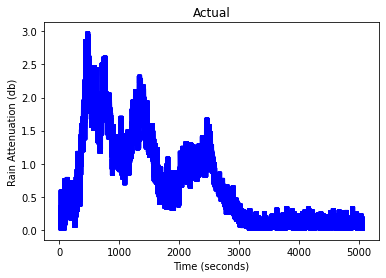

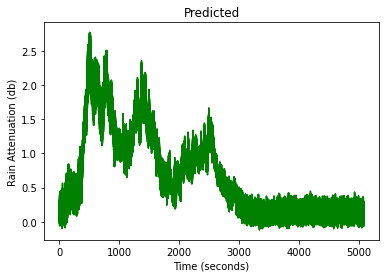

In [ ]:
plt.plot(ttest, 'b')
plt.title('Actual')
plt.ylabel('Rain Attenuation (db)')
plt.xlabel('Time (seconds)')
plt.show()

plt.plot(p_test, 'g')
plt.title('Predicted')
plt.ylabel('Rain Attenuation (db)')
plt.xlabel('Time (seconds)')
plt.show()

In [ ]:
print(sum(scores)/len(scores))

0.5620213369045617
